In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import netcdf

## Shallow Water Waves

Shallow Water system with rotation is capable of exhibiting many of the oscillatory patterns observed in the true atmosphere.

$$ \begin{align}
\frac{D\textbf{u}}{Dt} + \textbf{f} \times \textbf{u} &= -\nabla \phi \\
\frac{\partial \phi}{\partial t} &= \nabla \cdot (\textbf{u} \phi) \\
\end{align} $$


### Unforced systems

Consider the model initialised with a random geopotential surface, no friction and no forcing.
As we allow the model to evolve initially it consists solely of gravity waves as the local gradient of the uneven height forces waves radially outwards.
Due to the rotation of the earth, Kelvin waves are generated along the equator, Rossby waves propagate due to the conservation of potential vorticity.

In [2]:
## some useful constants
oneday = 86400.00
rearth = 6371220.00
twoomega = 1.4584e-4  
gravity = 9.80616
pi2 = np.pi*2.0

In [101]:
import matplotlib

def set_font(size=12, font='Myriad Pro'):
    fonta = {'family' : font,  
             'weight' : 'normal',
             'style'  : 'normal',
             'size'   : size}
    matplotlib.rc('font', **fonta)

set_font()
matplotlib.get_cachedir()

u'/home/links/jp492/.cache/matplotlib'

In [4]:
## some useful functions
import os

def best_fit(xs, ys):
    """Using the method of least squares, return the gradient
    and y-intercept of the line of best fit through xs and ys."""
    A = np.array([xs, np.ones(len(xs))])
    return np.linalg.lstsq(A.T,ys)[0]

RESAVE_ALL_IMAGES = False
def save_chart(filename, overwrite=False):
    name = filename.split('.')
    if len(name) >= 2:
        ext = name[-1]
    else:
        ext = 'pdf'
        filename = filename+'.pdf'
    if (os.path.isfile('../images/'+filename) and overwrite is False) or (RESAVE_ALL_IMAGES is True):
        print('save_chart: not overwriting existing file') 
        return
    plt.tight_layout()
    plt.savefig('../images/'+filename, dpi=300, format=ext)
    print('save_chart: image saved to images/'+filename)
    
def save_charts(chartname, overwrite=False):
    """Save as both .png and .pdf"""
    save_chart(chartname+'.png', overwrite=overwrite)
    save_chart(chartname, overwrite=overwrite)


In [5]:
## NetCDF data retrieval functions

def get_var(var, filename):
    f = netcdf.netcdf_file(filename)
    data = f.variables[var].data.copy()
    dims = [f.variables[dim].data.copy() for dim in f.variables[var].dimensions]
    f.close()
    return (dims, data)

def get_meta(filename):
    with netcdf.netcdf_file(filename) as f:
        return f._attributes.copy()
    
def describe(filename):
    """Return the description from a file if it has one."""
    m = get_meta(filename)
    if 'description' in m:
        return m['description']
    else:
        return 'No description available.'

def convert_dims(dims):
    """Convert the dimensions to standard time (days), lon (degrees), lat (degrees)."""
    return dims[0] / oneday, dims[1] * 180 / np.pi, dims[2] * 180 / np.pi

In [6]:
### Diagnostic Functions

def mass(phi):
    """Returns the total mass of the system"""
    nx = phi.shape[-2]
    ny = phi.shape[-1]
    dx = 2*np.pi / nx
    dy = np.pi / ny
    j = np.arange(ny)
    yp = (j+0.5-(ny/2))*dy
    cosp = np.cos(yp)
    area = dx*dy*cosp
    return (phi * area[np.newaxis, :]).sum((-2,-1))



In [7]:
## Plotting functions
def plot_map(data, size=(12,8)):
    nx, ny = data.shape
    lats = np.linspace(-90, 90, ny)
    lons = np.linspace(0, 360, nx)
    plt.figure(figsize=size)
    plt.pcolormesh(lons, lats, data.T, cmap=plt.cm.seismic)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.xlim((0, 360))
    plt.ylim((-90, 90))
    
def plot_mass_added(dims, phi, norm_fac=1.0):
    """Plot the total mass of a system over time."""
    q0 = norm_fac
    mass_over_time = mass(phi)
    initial_mass = mass_over_time[0]
    times = dims[0] / oneday
    plt.plot(times, (mass_over_time - initial_mass)/ q0)
    plt.xlabel('time (days)')
    plt.ylabel('total mass added')
    
def lat_ticks():
    """Set the x-axis to be Latitude with a standard set of ticks"""
    plt.xlabel('Latitude')
    plt.xlim((-90, 90))
    plt.xticks((-90,-60,-30,-15,0,15,30,60,90))
    

No forcing, just randomised geopotential surface.
save_chart: not overwriting existing file


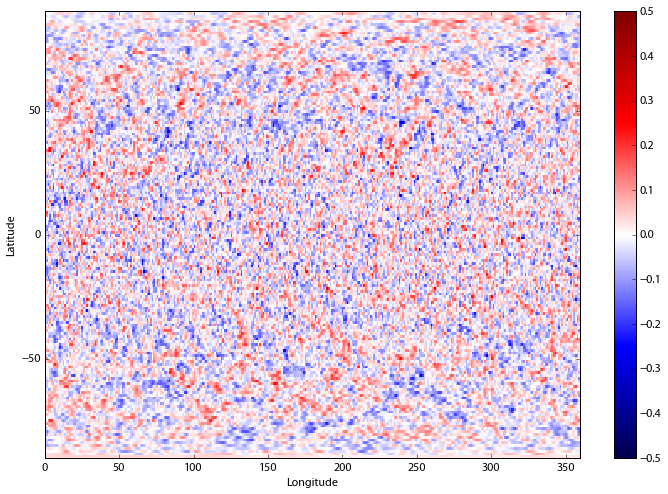

In [8]:
no_forcing_file = 'data/run_data_20150728_140709.nc'
print describe(no_forcing_file)
dims, phi = get_var('phi', no_forcing_file)
phiref = 100.0
plot_map(phi[1000] - phi[1000].mean())
plt.clim(-0.5, 0.5)
plt.colorbar()
save_chart('noforce_phi_1000.png')

save_chart: not overwriting existing file


/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:51: RuntimeWarning: invalid value encountered in sqrt
/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:52: RuntimeWarning: invalid value encountered in sqrt


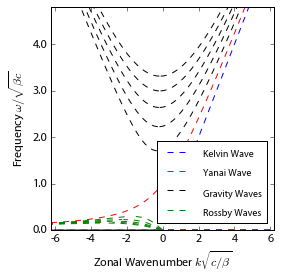

In [9]:
# Wheeler-Kiladis plot
# For symmetric responses about the equator plot the odd modes m = 1,3,5,7...
# For antisymmetric responses about the equator and
# the mixed-Rossby gravity waves plot the even modes m = 0,2,4,6...


# this can be plotted over a spectra
def plot_wavelines(c, m=(1,3,5,7), kelvin=True, color=None, linestyle='--'):
    """Plot the analytic solutions to Kelvin, Rossby and gravity waves 
    on a wavenumber-frequency spectrum.
        `c` is wavespeed in [m.s^-1]
        `m` are the eigenvalues of the Rossby and gravity wave solutions to be plotted
    Plots lines in SI units"""
    T = 5.0*oneday                                    # number of seconds over which time window is observed

    nx = 1000                                         # number of sample points in space
    nt = 1000                                         # temporal sample points

    khat = np.linspace(-nx/2, nx/2, 2000000)          # nondimensional wavenumber
    what = np.linspace(-nt/2, nt/2, 2000000)          # nondimensional frequency

    k = khat / rearth                                 # in [wavelengths.m^-1]
    w = what * pi2 / T                                # in [wavelengths.s^-1]

    # c = np.sqrt(phiref)     # wavespeed in [m.s^-1]
    beta = twoomega/rearth  # in units [s^-1.m^-1]
    
    if color is None:
        kcolor, gcolor, rcolor, ycolor = ('blue', 'black', 'green', 'red')
    else:
        try:
            kcolor, gcolor, rcolor, ycolor = color
        except:  # not a list of 4 colors, set all 4 to the same value
            kcolor = gcolor = rcolor = ycolor = color
    ls = linestyle
    
    # plot analytic solutions to equatorial waves
    # a. kelvin waves
    #   w = ck
    if kelvin:
        kline, = plt.plot(k, c*k, color=kcolor, linestyle=ls)
        kline.set_label('Kelvin Wave')

    # b. rossby waves
    # c. gravity waves
    #   w^2 - c^2 k^2 - \beta c^2 k / w = (2m+1) \beta c
    # The dispersion relation is quadratic in k and cubic in w
    # so solve for k and plot that way
    # plot several modes of m
    for mi in m:
        gkp = -(beta / (2*w)) + 0.5*np.sqrt((beta/w - 2*w/c)**2 - 8*mi*beta/c)
        gkm = -(beta / (2*w)) - 0.5*np.sqrt((beta/w - 2*w/c)**2 - 8*mi*beta/c)
        if mi != 0:
            # Gravity waves: high frequency
            gline, = plt.plot(gkp[w > 0.00001], w[w > 0.00001], color=gcolor, linestyle=ls)
            plt.plot(gkm[w > 0.00001], w[w > 0.00001], color=gcolor, linestyle=ls)
            # Rossby waves: low frequency
            rline, = plt.plot(gkp[w < 0.00001], w[w < 0.00001], color=rcolor, linestyle=ls)
            plt.plot(gkm[w < 0.00001], w[w < 0.00001], color=rcolor, linestyle=ls)
        else:
            # d. Yanai Wave: when m = 0 only one solution is physically relevant
            # w = kc/2 ± 1/2 sqrt(k^2 c^2 + 4 \beta c)
            yline, = plt.plot(k, k*c/2 + 0.5*np.sqrt(k**2*c**2 + 4*beta*c), color=ycolor, linestyle=ls)
            yline.set_label('Yanai Wave')

    gline.set_label('Gravity Waves')
    rline.set_label('Rossby Waves')
    
def axis_cycles_per_day():
    non_dim_xticks = np.linspace(-100, 100, 21, dtype=np.int32)
    dim_xticks = non_dim_xticks / rearth
    non_dim_yticks = np.linspace(0, 1, 11)
    dim_yticks = non_dim_yticks/oneday*pi2
    plt.xticks(dim_xticks, non_dim_xticks)
    plt.yticks(dim_yticks, non_dim_yticks)
    plt.xlabel('Zonal Wavenumber $k$')
    plt.ylabel('Frequency $\omega$ (cycles per day)')

    
def axis_non_dim(c=10.0):
    beta = twoomega/rearth  # in units [s^-1.m^-1]
    non_dim_xticks = np.linspace(-10, 10, 11, dtype=np.int32)
    dim_xticks = non_dim_xticks / np.sqrt(c/beta)
    non_dim_yticks = np.linspace(0, 4, 5)
    dim_yticks = non_dim_yticks * np.sqrt(beta*c)
    plt.xticks(dim_xticks, non_dim_xticks)
    plt.yticks(dim_yticks, non_dim_yticks)
    plt.xlabel(r'Zonal Wavenumber $k \sqrt{c/\beta}$')
    plt.ylabel(r'Frequency $\omega / \sqrt{\beta c}$')

phiref = 100.0

plt.figure(figsize=(4,4))

plot_wavelines(np.sqrt(phiref), m=(0,1,2,3,4,5))

plt.legend(loc='lower right')
plt.setp(plt.gca().get_legend().get_texts(), fontsize='small')
plt.xlabel('wavenumber [$m^{-1}$]')
plt.ylabel('frequency [$s^{-1}$]')


axis_non_dim(c=10)
plt.xlim((-60/rearth, 60/rearth))    # show up to wavenumber +/- 100 
plt.ylim((0, 1.0*pi2/oneday))          # show positive frequencies, up to one wavelength per day


save_chart('basic_wk_yanai.pdf')

### Wheeler Kiladis spectral analysis

Based of the information in their original paper, zonal velocity is converted into a power spectra using the cleaning methods described therein.

1. The mean and trend of the dataset are first removed by subtraction of the least-squares fit of mean velocity over time from the raw data to obtain perturbations about a zero state.
2. The first and last 10 time samples are tapered to zero to mimic a response that is periodic in time and avoid spurious discontinuities from generating false frequency signals, known as spectral leakage [1]
3. At each latitude a Fast Fourier Transform (FFT) is performed zonally to obtain planetary wavenumber spectra.
4. These complex wavenumber coefficients are in turn transformed by FFT in time to obtain an individual time-space spectrum at each latitude.
5. Symmetric responses about the equator are considered by summing spectra within the trop- ical region, in this case defined to be ±30o of the equator.
6. The wave spectra are finally converted to power spectra by taking the absolute square of the complex coefficients.


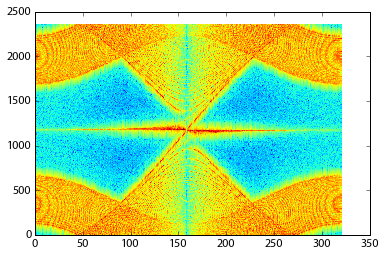

In [10]:
def kiladis_spectra(dims, u, spinup=0):
    """Perform Wheeler-Kiladis Spectral Analysis on variable u.

        spinup: discard the first `spinup` days as initialisation

    Returns frequency-wavenumber spectra for each latitude.
    """
    times, lons, lats = convert_dims(dims)

    v = u[times > spinup, :, :]
    ts = times[times > spinup]

    fts = []
    for j, lat in enumerate(lats):
        data = v[:,:,j]                    # u in time and longitude at given latitude
        lng_avg = data.mean((1))           # average u at each timestep
        m, c = best_fit(ts, lng_avg)       # trend in time

        # remove the trend of u over time to leave perturbations centred on zero
        perturbations = data - (m*ts + c)[:, np.newaxis]

        # window tapering - make the ends of the time window approach zero
        #                 - use a cos^2 profile over a small number of samples at each end
        taper = 30
        perturbations[:taper,:] = perturbations[:taper,:] * (np.cos(np.linspace(-np.pi/2, 0, taper))**2)[:, np.newaxis]
        perturbations[-taper:,:] = perturbations[-taper:,:] * (np.cos(np.linspace(0, np.pi/2, taper))**2)[:, np.newaxis]


        lft = np.fft.fft(perturbations, axis=1)     # FFT in space
        tft = np.fft.fft(lft, axis=0)               # FFT in time
        fts.append(np.fft.fftshift(tft))
    fts = np.array(fts)
    # fourier transform in numpy is defined by exp(-2π i (kx + wt)) 
    # but we want exp(kx - wt) so need to negate the x-domain
    fts = fts[:, :, ::-1]
    return fts

spectra = kiladis_spectra(*get_var('u', no_forcing_file), spinup=10)
plt.pcolormesh(np.log(np.abs(spectra[80])**2))

The analysis we wish to perform here is of waves occurring in the tropics.

We define a mask for the tropical region (defined here as ±15º about the equator).

In [11]:
## some useful globals
times, lons, lats = convert_dims(dims)

# slices for selecting only specific regions
tropics = np.abs(lats) <= 15                     # Within ±15º of the equator
stropics = np.logical_and(-15 < lats, lats < 0)  # Southern tropics
ntropics = np.logical_and(0 < lats, lats < 15)   # Northern tropics

### Background subtraction

Wheeler & Kiladis suggest removing the background noise from the spectra by

> smoothing many times with a 1-2-1 filter in frequency and wavenumber.

They have used a somewhat complicated (and not justified in their paper) set of parameters, choosing to apply the filter 10 times in frequency and then either 10 or 40 times for wavenumbers at low and high frequency respectively.

Empirical evidence suggests that the use of such a scheme is not necessary for data generated by this simple case where data is model generated, not atmospheric observations.
A simple scheme of 10 times application in frequency only was shown to have good results and this is the default for the function `remove_background`.

/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/numpy/ma/core.py:3017: ComplexWarning: Casting complex values to real discards the imaginary part
  output = self._data.astype(newtype).view(type(self))
/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/matplotlib/colors.py:917: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin = float(vmin)
/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/matplotlib/colors.py:918: ComplexWarning: Casting complex values to real discards the imaginary part
  vmax = float(vmax)


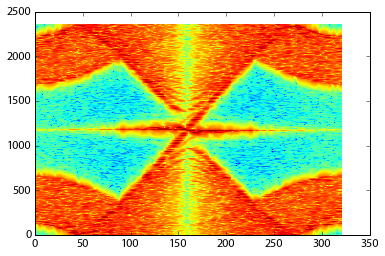

In [12]:
import scipy.signal

def power(spectra):
    return np.abs(spectra)**2


def background(spectra, fsteps=10, ksteps=10):
    """Uses a 1-2-1 filter to generate 'red noise' background field for a spectra (as per WK1998)
        `fsteps` is the number of times to apply the filter in the frequency direction
        `ksteps` is the number of times to apply the filter in the wavenumber direction
    
    Returns a background field of same dimensions as `spectra`.
    """
    # create a 1D 1-2-1 averaging footprint
    bgf = spectra
    for i in range(fsteps):
        # repeated application of the 1-2-1 blur filter to the spectra
        footprint = np.array([[0,1,0], [0,2,0], [0,1,0]]) / 4.0
        bgf = scipy.signal.convolve2d(bgf, footprint, mode='same', boundary='wrap')
    for i in range(ksteps):
        # repeated application of the 1-2-1 blur filter to the spectra
        footprint = np.array([[0,0,0], [1,2,1], [0,0,0]]) / 4.0
        bgf = scipy.signal.convolve2d(bgf, footprint, mode='same', boundary='wrap')
    
    return bgf

def remove_background(spectra):
    """A simple background removal to eliminate frequency noise."""
    bg = background(spectra, fsteps=10, ksteps=0)
    return spectra - bg

plt.pcolormesh(np.log(background(spectra[80])))

save_chart: not overwriting existing file


/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:51: RuntimeWarning: invalid value encountered in sqrt
/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:52: RuntimeWarning: invalid value encountered in sqrt


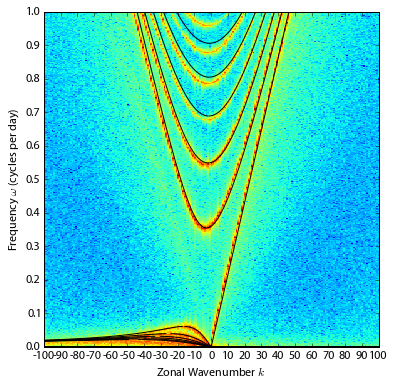

In [13]:
def plot_power_spectra(spectra, show_analytic=True, m=(1,3,5,7,9,11), kelvin=True, phiref=100.0, dt=None):
    nw, nk = spectra.shape
    if dt is None:
        T = (times[1] - times[0])*nw*oneday
    else:
        T = dt*nw*oneday
    ks = np.arange(-nk/2, nk/2)  # non-dim wavenumber and frequency
    ws = np.arange(-nw/2, nw/2)

    ksd = ks / rearth            # dimmed wavenumber and frequency
    wsd = ws * pi2 / T

    plt.pcolormesh(ksd, wsd, np.log(spectra))
    if show_analytic:
        plot_wavelines(np.sqrt(phiref), m, kelvin, color='black', linestyle='-')

    plt.xlim((-100/rearth, 100/rearth))    # show up to wavenumber +/- 100 
    plt.ylim((0, 1.0*pi2/oneday))          # show positive frequencies, up to one wavelength per day
    plt.xlabel('wavenumber $k$')
    plt.ylabel('frequency $\omega$')

    
plt.figure(figsize=(6,6))

# with background
symmetric_power = power(spectra[tropics].sum(0))

# without background
symmetric_power = power(remove_background(spectra[tropics].sum(0)))
plot_power_spectra(symmetric_power)
#axis_non_dim()
axis_cycles_per_day()
save_chart('no_forcing_spectra.png')

save_chart: not overwriting existing file


/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:51: RuntimeWarning: invalid value encountered in sqrt
/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:52: RuntimeWarning: invalid value encountered in sqrt


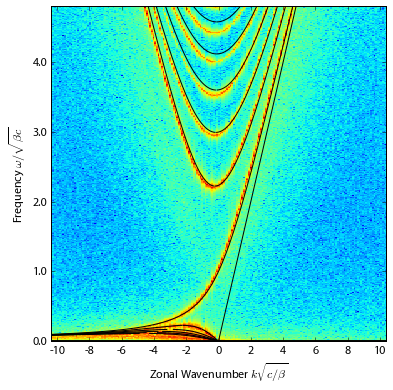

In [14]:
## Plot the anti-symmetric modes
plt.figure(figsize=(6,6))

# without background
asym_power = power(remove_background(spectra[stropics].sum(0) - spectra[ntropics].sum(0)))
plot_power_spectra(asym_power, m=(0,2,4,6,8,10))
axis_non_dim()
save_chart('no_forcing_spectra_asym.png')

save_chart: not overwriting existing file


/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:51: RuntimeWarning: invalid value encountered in sqrt
/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:52: RuntimeWarning: invalid value encountered in sqrt


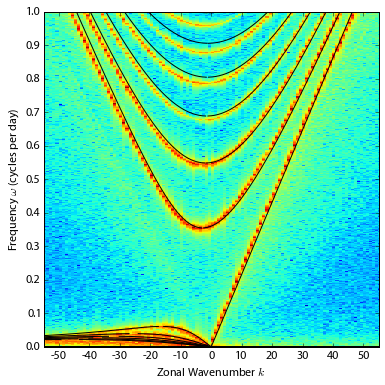

In [15]:
plt.figure(figsize=(6,6))
plot_power_spectra(symmetric_power)
axis_cycles_per_day()
plt.xlim((-55/rearth, 55/rearth))
save_chart('sym_spectra.pdf')

save_chart: not overwriting existing file


/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:51: RuntimeWarning: invalid value encountered in sqrt
/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:52: RuntimeWarning: invalid value encountered in sqrt


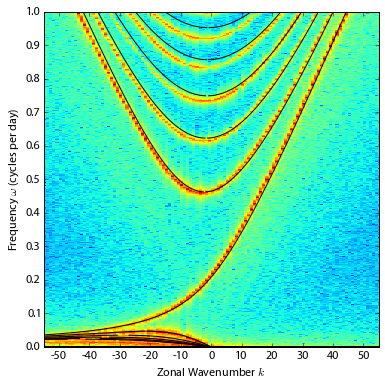

In [16]:
plt.figure(figsize=(6,6))
plot_power_spectra(asym_power, m=(0,2,4,6,8,10),kelvin=False)
axis_cycles_per_day()
plt.xlim((-55/rearth, 55/rearth))
save_chart('asym_spectra.pdf')

## Forced Systems


$$ \frac{\partial \phi}{\partial t} = \nabla \cdot (\textbf{u} \phi) + q - \frac{(\phi - \phi_{ref})}{\tau_c} $$

## Experiment 3 - Relaxation back to $\phi_{ref}$

**Basic Parameters**
* run length: 600 days
* dt = 900s
* grid size: (320, 160)
* $\phi_{ref} = 100$

**Forcing parameters**
* $R_0 = 3º$ 
* $\tau_c = 1 \text{ day}$
* $q_0 = 0.02$
* $\tau_r = 10 \text{ days}$

**Forcing setup**
* sink: $ r $
* source: $ q $
* threshold: $\phi_{ref} + ( \exp(-(\frac{\theta}{5 \cdot R_0})^2) - 0.3) \cdot q_0 \frac{\tau_c}{\Delta t}$
* initial conditions: $\phi_{ref} + q_0 \frac{\tau_c}{\Delta t} \cdot \text{rand}[0,1] $

**Notes**

The sink term of $\phi$ is now a relaxation back to $\phi_{ref}$.  i.e. 

$$ \frac{\partial \phi}{\partial t} = \nabla \cdot (\textbf{u} \phi) + q - \frac{(\phi - \phi_{ref})}{\tau_c} $$

The threshold is gaussian in shape, slightly below $\phi_{ref}$ at the poles to inhibit convection outside of the tropics.

Strong gravity waves should be dampened by the relaxation.  The time of convective event has also been extended to smooth the velocity acceleration induced and prevent large ripples forming.

Gaussian sink profile. Relax height back to phiref q=0.02.  sigma0=5d-4.  Longer duration events tauc=1day
save_chart: not overwriting existing file


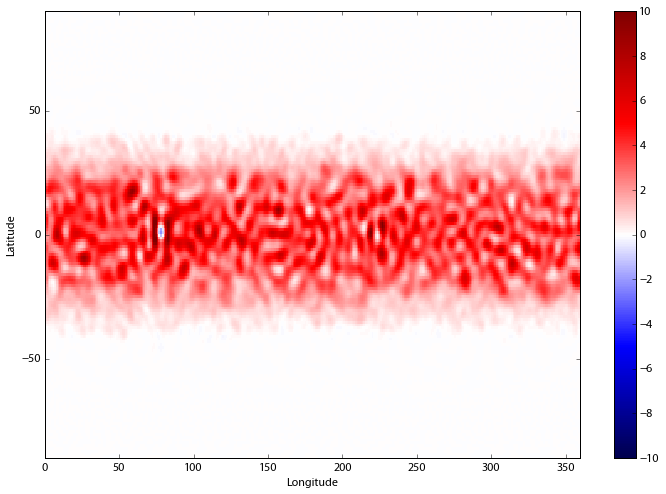

In [17]:
relax_file = 'data/run_data_20150708_195010.nc'
print describe(relax_file)
dims, phi = get_var('phi', relax_file)
phiref = 100.0
plot_map(phi[1000] - phiref)
plt.clim(-10, 10)
plt.colorbar()
save_chart('relax_phi_1000.png')

save_chart: not overwriting existing file
save_chart: image saved to images/relax_spectra_sym.pdf


/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:51: RuntimeWarning: invalid value encountered in sqrt
/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:52: RuntimeWarning: invalid value encountered in sqrt


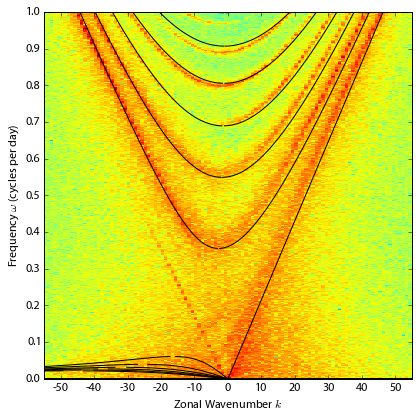

In [198]:
relax_spectra = kiladis_spectra(*get_var('u', relax_file), spinup=140)

plt.figure(figsize=(6,6))

# without background
rsym_power = power(remove_background(relax_spectra[tropics].sum(0)))
rasym_power = power(remove_background(relax_spectra[stropics].sum(0) - relax_spectra[ntropics].sum(0)))
plot_power_spectra(rsym_power)
axis_cycles_per_day()
plt.xlim((-55/rearth, 55/rearth))
save_chart('relax_spectra_sym.png')
save_chart('relax_spectra_sym')

save_chart: not overwriting existing file
save_chart: image saved to images/relax_spectra_asym.pdf


/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:51: RuntimeWarning: invalid value encountered in sqrt
/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:52: RuntimeWarning: invalid value encountered in sqrt


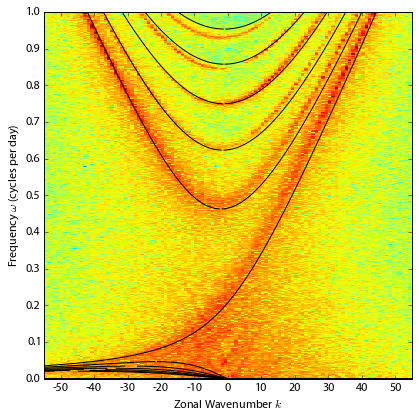

In [199]:
plt.figure(figsize=(6,6))
plot_power_spectra(rasym_power, m=(0,2,4,6,8,10,12), kelvin=False)
axis_cycles_per_day()
plt.xlim((-55/rearth, 55/rearth))
save_chart('relax_spectra_asym.png')
save_chart('relax_spectra_asym')

## Hovmoller Plots


In [204]:
dims, u = get_var('u', relax_file)
times, lons, lats = convert_dims(dims)


save_chart: image saved to images/relax_hov_phi.png
save_chart: image saved to images/relax_hov_phi.pdf


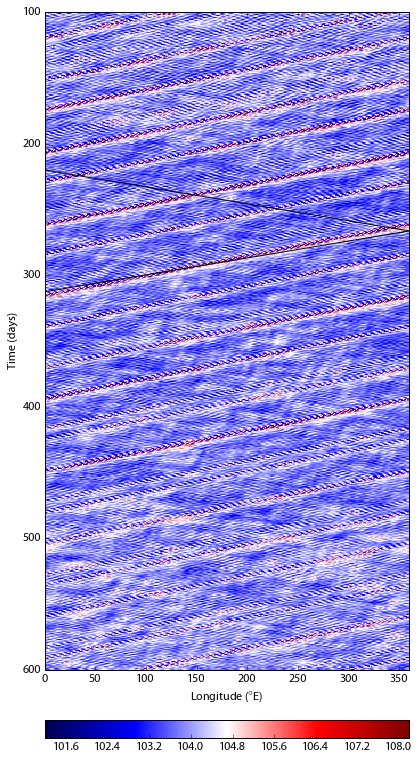

In [214]:
def hovmoller_plot(dims, u, spinup=0):
    times, lons, lats = convert_dims(dims)
    plt.pcolormesh(lons, times[times > spinup], u[times > spinup][:,:, tropics].mean(2), cmap=plt.cm.seismic)
    plt.ylim(times[-1], spinup) # invert the y-axis so time goes down chart
    plt.xlim((0, 360))
    plt.xlabel(r'Longitude ($\degree$E)')
    plt.ylabel('Time (days)')

def hovmoller_speed_line(c, at_day, color='black', linestyle='--'):
    """Plot a line on a Hovmoller chart at given speed c, starting at a given day"""
    oncearoundworld = (rearth*pi2 / c)/oneday
    plt.plot([0, 360],[at_day, at_day+oncearoundworld], color=color, linestyle=linestyle)
    
def hovmoller_var(var, filename, kelvin_at=200, c=10):
    hovmoller_plot(*get_var(var, filename), spinup=100)
    # plot a kelvin wave line
    if not kelvin_at is None:
        kat = kelvin_at   # plot the kelvin line at day `kelvin_at`
        hovmoller_speed_line(c, kelvin_at, color='black', linestyle='-')
        hovmoller_speed_line(-c, kelvin_at+2*(rearth*pi2 / c)/oneday, color='black', linestyle='-')

plt.figure(figsize=(6,12))
hovmoller_var('phi', relax_file, c=10, kelvin_at=220)
plt.colorbar(orientation='horizontal', pad=0.06)
save_charts('relax_hov_phi', overwrite=True)

save_chart: image saved to images/relax_hov_u.png
save_chart: image saved to images/relax_hov_u.pdf


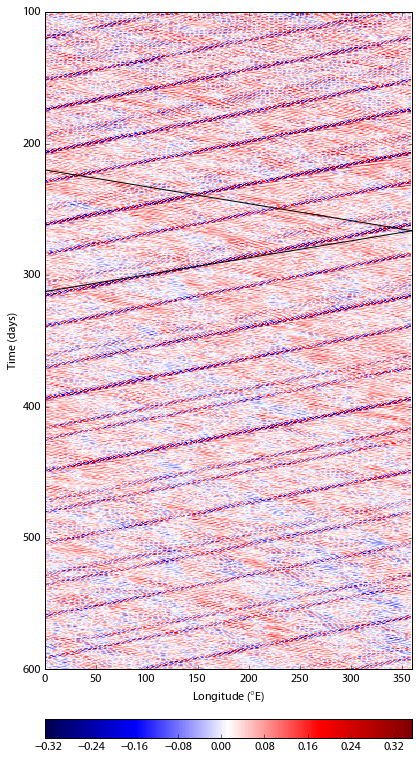

In [215]:
plt.figure(figsize=(6,12))
hovmoller_var('u', relax_file, c=10, kelvin_at=220)
plt.colorbar(orientation='horizontal', pad=0.06)
save_charts('relax_hov_u', overwrite=True)

save_chart: not overwriting existing file


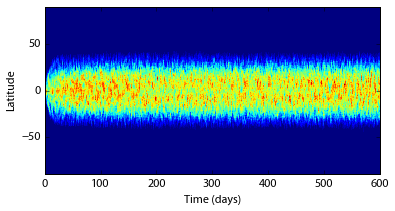

In [218]:
def plot_convection(dims, conv):
    times, lons, lats = convert_dims(dims)
    plt.pcolormesh(times, lats, conv.sum(1).T)
    plt.xlabel('Time (days)')
    plt.ylabel('Latitude')
    plt.ylim((-90,90))

dims, conv = get_var('phi_lat', relax_file)
plt.figure(figsize=(6,3))
plot_convection(dims, conv)
save_chart('relax_convection.pdf')

save_chart: not overwriting existing file


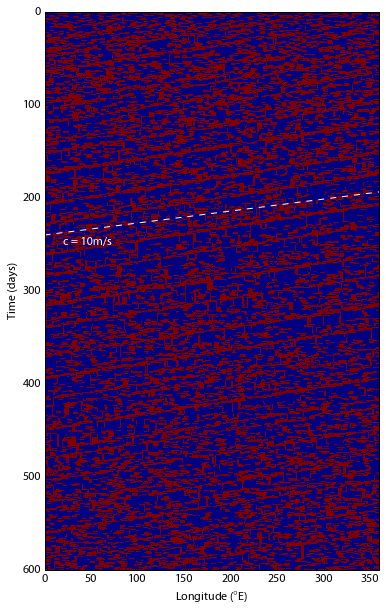

In [219]:
plt.figure(figsize=(6,10))
times, lons, lats = convert_dims(dims)
plt.pcolormesh(lons, times, conv[:,:,80])
plt.ylim(times[-1], 0) # invert the y-axis so time goes down chart
plt.xlim((0, 360))
plt.xlabel(r'Longitude ($\degree$E)')
plt.ylabel('Time (days)')
hovmoller_speed_line(-10, 240, color='white')
plt.text(20, 250, 'c = 10m/s', color='white')
save_chart('relax_80_conv_on.pdf')

In [220]:
dims, phi = get_var('phi', relax_file)

save_chart: image saved to images/lat80_hov.png
save_chart: image saved to images/lat80_hov.pdf


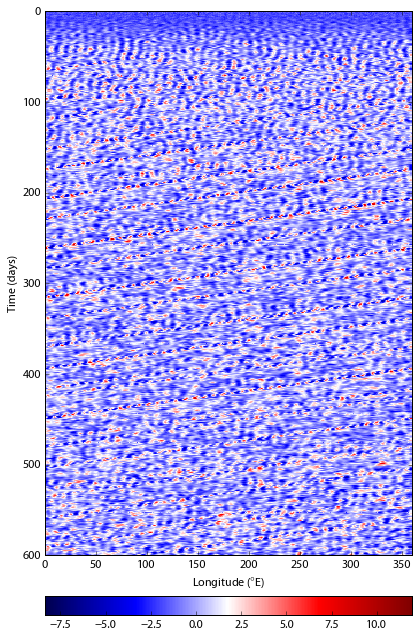

In [225]:
plt.figure(figsize=(6,10))
plt.pcolormesh(lons, times, phi[:,:,80] - phi[:,:,80].mean(), cmap=plt.cm.seismic)
#plt.colorbar(orientation='horizontal', pad=0.06)
plt.ylim(times[-1], 0) # invert the y-axis so time goes down chart
plt.xlim((0, 360))
plt.xlabel(r'Longitude ($\degree$E)')
plt.ylabel('Time (days)')
save_charts('lat80_hov', overwrite=True)

save_chart: not overwriting existing file


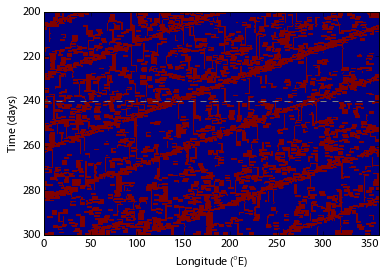

In [26]:
plt.figure(figsize=(6,4))
plt.pcolormesh(lons, times[800:1200], conv[800:1200,:,80])
plt.ylim(times[1200], times[800]) # invert the y-axis so time goes down chart
plt.xlim((0, 360))
plt.xlabel(r'Longitude ($\degree$E)')
plt.ylabel('Time (days)')
plt.hlines(240, 0, 360, color='grey', linestyle='--')
save_chart('lat80_subsec.pdf')

save_chart: not overwriting existing file


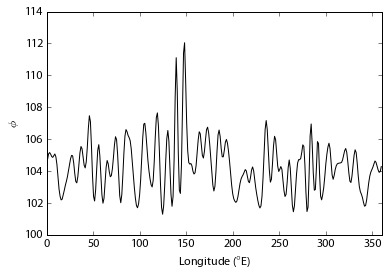

In [27]:
plt.figure(figsize=(6,4))
plt.plot(lons,phi[240*4,:,80], color='black')
plt.ylabel('$\phi$')
plt.xlabel(r'Longitude ($\degree$E)')
plt.xlim((0, 360))
save_chart('lat80_time240.pdf')

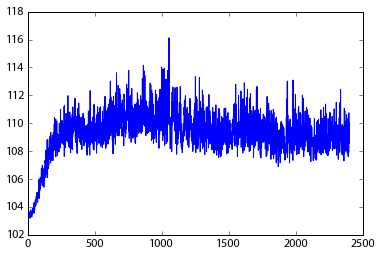

In [28]:
eq = phi[:,:,80]
plt.plot(np.max(eq, 1))

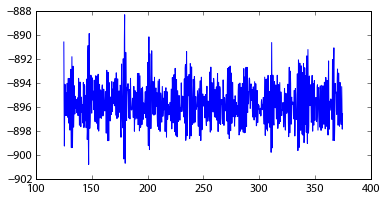

In [29]:
# consider a single line of longitude and watch signals passing through
plt.figure(figsize=(6, 3))
plt.plot(times[500:1500], phi[500:1500,160,80]-1000)

#### Gill Pattern

Truncate the spectra at low wavenumber, low frequency and invert the transform

In [30]:
ospec = np.fft.fftshift(relax_spectra, axes=(1,2))
fspec = ospec[:,0:50, 0:10]   # select low frequency, low wavenumber
uspec = []
for j, lat in enumerate(lats):
    iftw = np.fft.ifft(fspec[j,:,:], n=1840, axis=0)  # use n to expand to full time domain again
    iftk = np.fft.ifft(iftw, n=320, axis=1)
    uspec.append(iftk)
    
uspec = np.array(uspec)
uspec.shape

(160, 1840, 320)

save_chart: not overwriting existing file


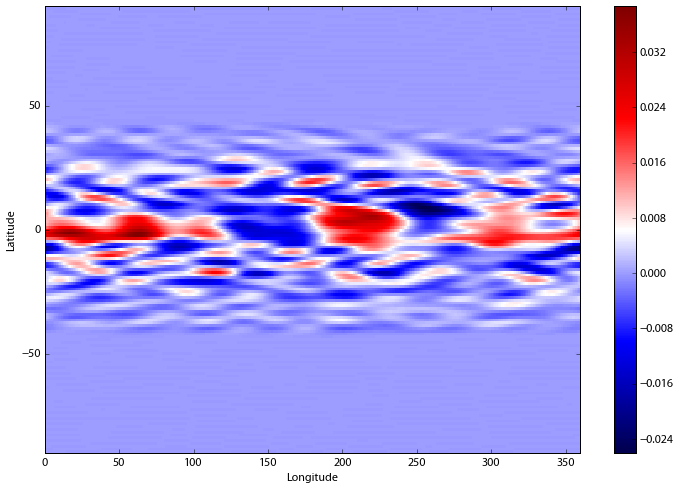

In [31]:
plot_map(np.real(uspec[:,950,:].T))
plt.colorbar()
save_chart('low_freq_pattern')

### Plotting meridional profile

In [32]:
_,phic = get_var('phi_c', relax_file)

save_chart: not overwriting existing file


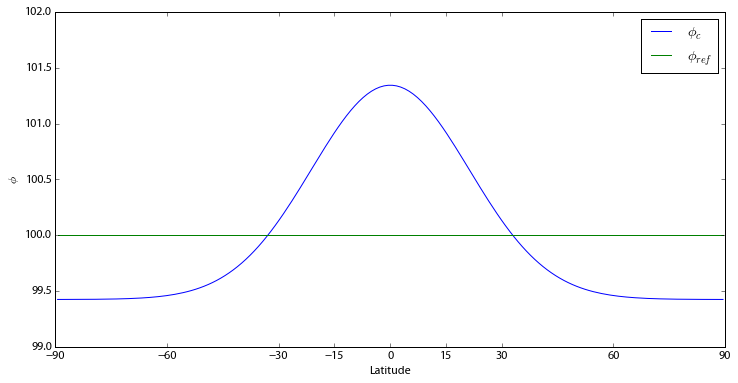

In [33]:
plt.figure(figsize=(12,6))
plt.plot(lats, phic[1,:], label='$\phi_c$')
plt.plot(lats, phiref*np.ones(160), label='$\phi_{ref}$')
lat_ticks()
plt.ylabel('$\phi$')
plt.ylim((99, 102))
plt.legend()
save_chart('phi_relax_schematic.pdf')

save_chart: not overwriting existing file


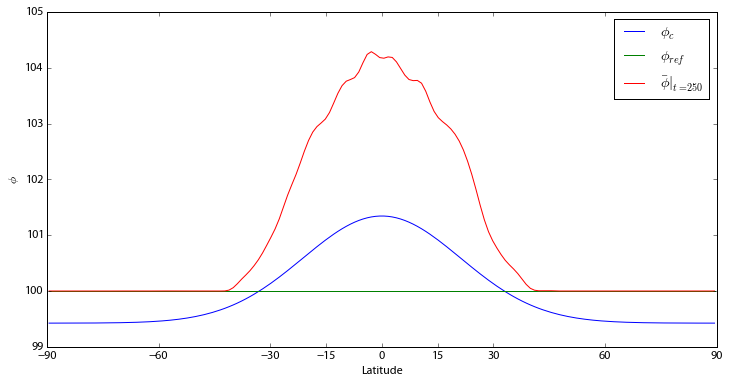

In [34]:
plt.figure(figsize=(12,6))
plt.plot(lats, phic[1,:], label='$\phi_c$')
plt.plot(lats, phiref*np.ones(160), label=r'$\phi_{ref}$')
plt.plot(lats, phi[1000].mean(0), label=r'$\left. \bar \phi \right|_{t=250}$')
lat_ticks()
plt.ylabel('$\phi$')
#plt.ylim((99, 102))
plt.legend()
save_chart('phi_1000_lat_profile.pdf')

### Sink or Source Driven?

When using the Yang/Ingerssol forcing scheme there are two choices to be made about how the system can be configured to promote increased convective activity in the tropics versus globally distributed initiation.
Either the threshold $\phi_c$ can be profiled to have a higher value at the equator than the poles.
Or the sink term can be profiled to remove mass at a greater rate at the equator than the poles.

Experiment 2. was setup to test which of these options would most impact the initiation of convective events over time.

#### Experiment 2 - Sink or Source driven initiation

$$\phi_c = \phi_{ref} + $$

In [35]:
sink_source_file = 'data/run_data_20150703_134935.nc'
_, phi_c = get_var('phi_c', sink_source_file)
_, r_sink = get_var('r_sink', sink_source_file)
_, conv = get_var('convection', sink_source_file)


save_chart: not overwriting existing file


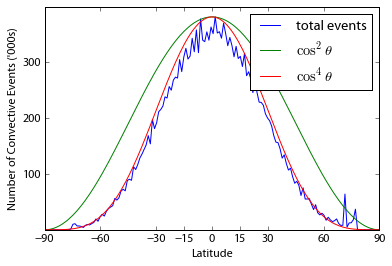

In [36]:
conv_by_lat = conv[300:].sum((0,1))

plt.figure(figsize=(6,4))
plt.plot(lats, conv_by_lat, label=r'total events')
plt.plot(lats,np.cos(dims[2])**2*conv_by_lat.max(), label=r'$\cos^2\theta$')
plt.plot(lats,np.cos(dims[2])**4*conv_by_lat.max(), label=r'$\cos^4\theta$')
lat_ticks()
plt.ylabel('Number of Convective Events (\'000s)')
plt.yticks((100000,200000,300000, ), (100, 200, 300))
plt.legend()
save_chart('sink_or_source.pdf')

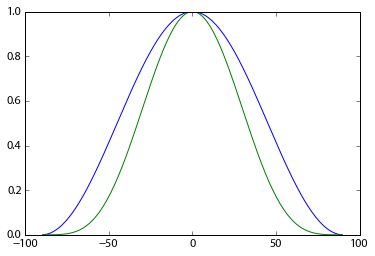

In [37]:
plt.plot(lats, np.cos(lats/180*np.pi)**2)
plt.plot(lats, np.cos(lats/180*np.pi)**4)

In [38]:
high_grid_file = 'data/run_data_20150807_125722.nc'
describe(high_grid_file)


'No Forcing.  Twice as many meridional grid squares'

/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:51: RuntimeWarning: invalid value encountered in sqrt
/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:52: RuntimeWarning: invalid value encountered in sqrt


save_chart: not overwriting existing file


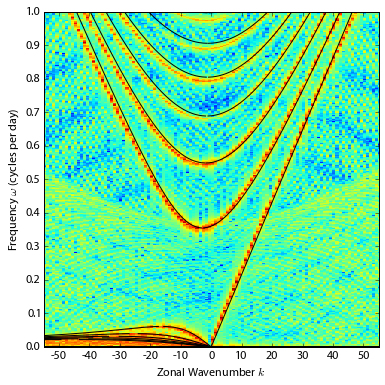

In [102]:
hdims, hu = get_var('u', high_grid_file)
hg_spec = kiladis_spectra(hdims, hu, spinup=140)
hhd = convert_dims(hdims)
plt.figure(figsize=(6,6))

# without background
hsym_power = power(remove_background(hg_spec[np.abs(hhd[2]) < 15].sum(0)))
#rasym_power = power(remove_background(hg_spec[stropics].sum(0) - hg_spec[ntropics].sum(0)))
plot_power_spectra(hsym_power)
axis_cycles_per_day()
plt.xlim((-55/rearth, 55/rearth))
save_chart('hig_res_spec.pdf')

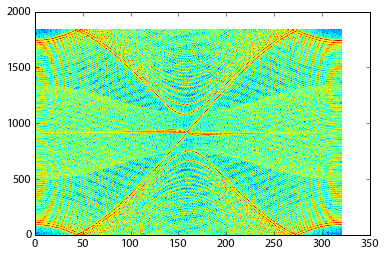

In [103]:
plt.pcolormesh(np.log(np.abs(hsym_power)))

In [104]:
low_dt_file = 'data/run_data_20150807_125924.nc'
describe(low_dt_file)


'No forcing.  half timestep.'

/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:51: RuntimeWarning: invalid value encountered in sqrt
/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:52: RuntimeWarning: invalid value encountered in sqrt


save_chart: not overwriting existing file


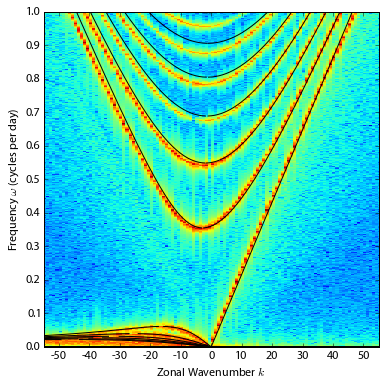

In [105]:
ldt_spec = kiladis_spectra(*get_var('u', low_dt_file), spinup=10)

plt.figure(figsize=(6,6))

# without background
ldt_power = power(remove_background(ldt_spec[tropics].sum(0)))
plot_power_spectra(ldt_power)
axis_cycles_per_day()
plt.xlim((-55/rearth, 55/rearth))
save_chart('low_dt_spec.pdf')

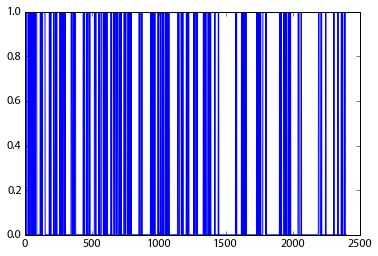

In [106]:
plt.plot(conv[:,280,80])

In [107]:
np.max(conv)

1.0

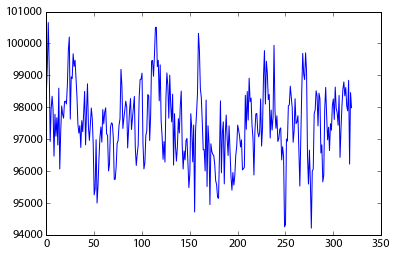

In [108]:
plt.plot(conv.sum((0,2)))

In [109]:
np.arange(0,320)[conv.sum((0,2))==np.max(conv.sum((0,2)))]

array([2])

In [160]:
single_event_file = 'data/run_data_20150626_175801.nc'
#single_event_file = '../../exeter_msc_2/endgame/data/run_data_20150812_102820.nc'  # reverse spin of earth
dims, sphi = get_var('phi', single_event_file)
phiref = 1000.0
sphi.shape

(566, 320, 160)

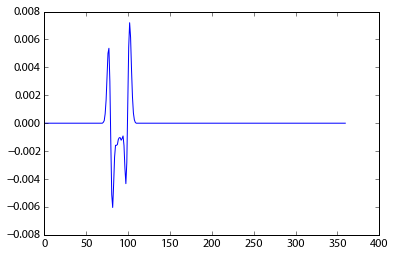

In [161]:
# single convective event initiated at (80, 80)
ts, lons, lats = convert_dims(dims)
plt.plot(lons, sphi[60,:,80]-phiref)

save_chart: image saved to images/single_event_evolve_reverse.pdf


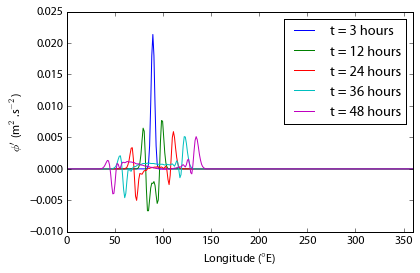

In [162]:
plt.figure(figsize=(6,4))
# plot the first 5 12 hour intervals at the equator
for hr in (3,12,24,36,48):
    d = sphi[hr*60*60/900,:,80]  # get data at equator at given hour
    plt.plot(lons, d-phiref, label='t = %d hours' % hr)
plt.legend(loc='upper right')
plt.xlim((0, 360))
#plt.vlines(89.43871182, -0.005,0.025)
plt.xlabel('Longitude ($\degree$E)')
plt.ylabel("$\phi'$  (m$^2$.s$^{-2}$)")
save_chart('single_event_evolve_reverse.pdf', overwrite=True)

save_chart: not overwriting existing file


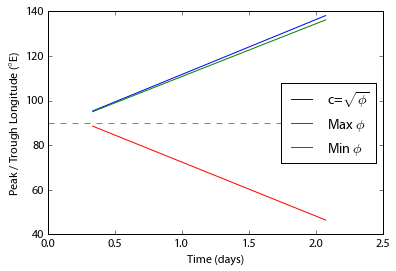

In [163]:
max_phi = sphi[:,:,80].max(1)
min_phi = sphi[:,:,80].min(1)

max_at = sphi[:, :, 80] == max_phi[:, np.newaxis]
min_at = sphi[:, :, 80] == min_phi[:, np.newaxis]

max_lon = np.array([lons[t][0] for t in max_at])
min_lon = np.array([lons[t][0] for t in min_at])

#plt.plot(ts[32:200], max_lon[32:200], label='Max $\phi$')
#plt.plot(ts[32:200], min_lon[32:200], label='Min $\phi$')

Mm, Mc = best_fit(ts[32:200], max_lon[32:200])
mm, mc = best_fit(ts[32:200], min_lon[32:200])


plt.figure(figsize=(6, 4))
plt.plot(ts[32:200], Mc+ts[32:200]*(np.sqrt(phiref)/rearth*oneday*180/np.pi), label='c=$\sqrt{\phi}$')
plt.plot(ts[32:200], Mc + Mm*ts[32:200], label='Max $\phi$')
plt.plot(ts[32:200], mc + mm*ts[32:200], label='Min $\phi$')
#plt.plot(ts[32:200], mc-ts[32:200]*(np.sqrt(phiref)/rearth*oneday*180/np.pi))
plt.hlines(90, ts[0], ts[200], color='grey', linestyle='--')
plt.xlabel('Time (days)')
plt.ylabel('Peak / Trough Longitude ($\degree$E)')
plt.legend(loc='center right')
save_chart('single_event_prop.pdf')

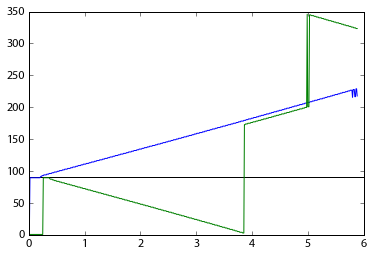

In [164]:
plt.plot(ts, max_lon, label='Max $\phi$')
plt.plot(ts, min_lon, label='Min $\phi$')
plt.hlines(90,0,6)

In [165]:
Mm, mm, np.sqrt(phiref)/rearth*oneday*180/np.pi

(23.646883284811359, -24.180839387554094, 24.570487493729065)

In [166]:
# speed in m/s
print('wave speed c = %.2fm/s' % np.sqrt(phiref))
print('trough speed:  %.2fm/s' % (-mm*rearth/oneday/180*np.pi))
print('peak   speed:  %.2fm/s' % (Mm*rearth/oneday/180*np.pi))

wave speed c = 31.62m/s
trough speed:  31.12m/s
peak   speed:  30.43m/s


save_chart: image saved to images/wave_prop.pdf


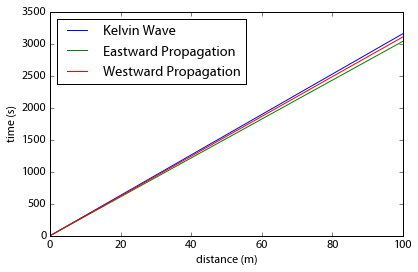

In [168]:
set_font(size=12)
plt.figure(figsize=(6,4))
xs = np.linspace(0, 100)
plt.plot(xs, xs*np.sqrt(phiref), label='Kelvin Wave')
plt.plot(xs, xs*(Mm*rearth/oneday/180*np.pi), label='Eastward Propagation')
plt.plot(xs, xs*(-mm*rearth/oneday/180*np.pi), label='Westward Propagation')
plt.legend(loc='upper left')
plt.xlabel('distance (m)')
plt.ylabel('time (s)')
save_chart('wave_prop', overwrite=True)

In [118]:
best_fit(max_lon[32:200]*np.pi/180*rearth, ts[32:200]*oneday)

array([  3.28335713e-02,  -3.17942172e+05])

(-90, 90)

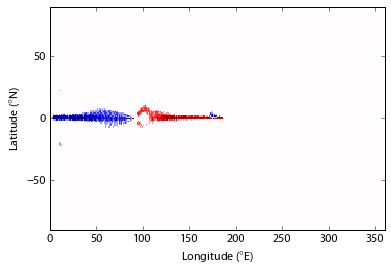

In [119]:
ssphi = sphi[32:400]
plt.pcolormesh(lons, lats, ((ssphi == ssphi.max((1,2))[:, np.newaxis, np.newaxis])*1).sum(0).T + ((ssphi == ssphi.min((1,2))[:, np.newaxis, np.newaxis])*-1).sum(0).T, cmap=plt.cm.seismic)
#plt.colorbar()
plt.xlabel('Longitude ($\degree$E)')
plt.ylabel('Latitude ($\degree$N)')
plt.clim((-5,5))
plt.xlim((0, 360))
plt.ylim((-90, 90))

In [120]:
sft = kiladis_spectra(dims, sphi, spinup=0)

/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:51: RuntimeWarning: invalid value encountered in sqrt
/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:52: RuntimeWarning: invalid value encountered in sqrt


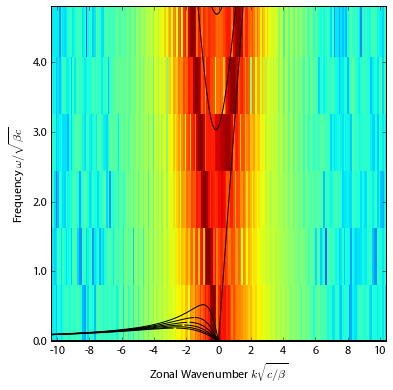

In [121]:
plt.figure(figsize=(6,6))
spw = power(remove_background(sft[tropics].sum(0)))[::-1]
plot_power_spectra(spw, show_analytic=True, phiref=1000.0, dt=900.0/oneday)
axis_non_dim()
#plt.pcolormesh(np.log(spw))

## High Wavenumber speed dilation

save_chart: not overwriting existing file


/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide
/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: RuntimeWarning: invalid value encountered in multiply
/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: RuntimeWarning: divide by zero encountered in divide
/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: RuntimeWarning: invalid value encountered in multiply
/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater


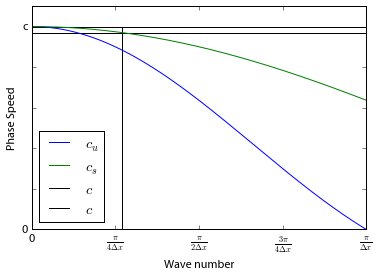

In [192]:
dx = pi2/320
k = np.arange(0, np.pi / dx, dx)
c = 10.0
cu = c / (k * dx) * np.sin(k*dx)
cs = 2*c / (k * dx) * np.sin(k*dx/2)
plt.hlines(c, k[0], k[-1], label='$c$')
plt.hlines(c*0.97, k[0], k[-1], label='$c$')
plt.vlines(k[cs > c*.97][-1], 0, c)
plt.plot(k,cu, label='$c_u$')
plt.plot(k,cs, label='$c_s$')
plt.xlabel('Wave number')
plt.ylabel('Phase Speed')
plt.ylim(0, 11)
plt.yticks((0, c, 2, 4, 6, 8), (0, 'c'))
plt.xticks(np.linspace(0, np.pi / dx, 5),
           (0, r'$\frac{\pi}{4 \Delta x}$', r'$\frac{\pi}{2 \Delta x}$',
               r'$\frac{3 \pi}{4 \Delta x}$', r'$\frac{\pi}{\Delta x}$'))
plt.xlim((0, np.pi / dx))
plt.legend(loc='lower left')
save_chart('numerical_phase_speed.pdf')

In [195]:
k[cs < c*.97][0]

/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


43.412883481793955

save_chart: not overwriting existing file


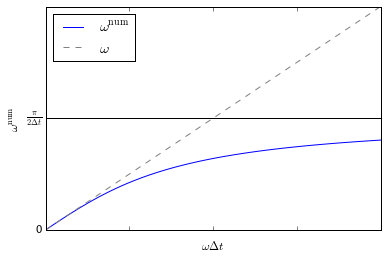

In [59]:
om = np.linspace(0, np.pi)
plt.figure(figsize=(6,4))
plt.plot(om, np.arctan(om), label=r'$\omega^\mathrm{num}$')
plt.plot(om, om, label=r'$\omega$', color='grey', linestyle='--')
plt.hlines(np.pi/2, 0, 10)
plt.ylim((0, np.pi))
plt.yticks((0, np.pi/2), (0, r'$\frac{\pi}{2 \Delta t}$'))
plt.xlim((0, np.pi))
plt.xticks((0,np.pi/4,np.pi/2,3*np.pi/4,np.pi), ())
plt.xlabel(r'$\omega \Delta t$')
plt.ylabel(r'$\omega^\mathrm{num}$')
plt.legend(loc='upper left')
save_chart('omega_damp.pdf')

## Experiment 1 - Tropically selective $\phi_c$

**Basic Parameters**
* run length: 600 days
* dt = 900s
* grid size: (320, 160)
* $\phi_{ref} = 100$

**Forcing parameters**
* $R_0 = 3º$ 
* $\tau_c = 0.25 \text{ days}$
* $q_0 = 0.01$
* $r_0 = 1.18\times10^{-4}$

**Forcing setup**
* sink: $ r = r_0$
* source: $ q $
* threshold: $\phi_{ref} - \frac{q_0 \tau_c}{R_0 \Delta t}(1.1 - \cos^2\theta)  $
* initial conditions: $\phi_{ref} + q_0 \frac{\tau_c}{\Delta t} \cdot \text{rand}[0,1] $

**Notes**



In [60]:
phic_file = 'data/run_data_20150819_161226.nc'
describe(phic_file)

'phi_c profiled like cos^2. constant sink.'

save_chart: image saved to images/phic_conv.png
save_chart: image saved to images/phic_conv.pdf


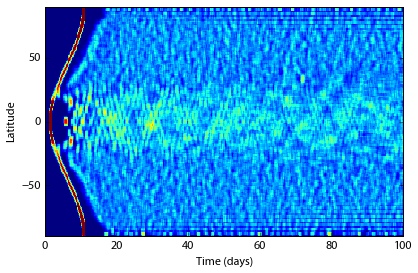

In [216]:
dims, conv = get_var('phi_lat', phic_file)
plt.figure(figsize=(6,4))
plot_convection(dims, conv)
plt.xlim((0, 100))
save_charts('phic_conv')

save_chart: image saved to images/exp1_phic_spec.png
save_chart: image saved to images/exp1_phic_spec.pdf


/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:51: RuntimeWarning: invalid value encountered in sqrt
/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:52: RuntimeWarning: invalid value encountered in sqrt


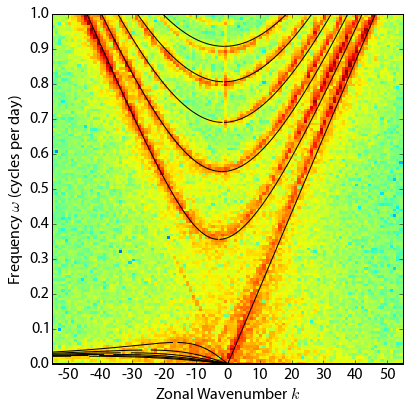

In [80]:
hdims, hu = get_var('u', phic_file)
hg_spec = kiladis_spectra(hdims, hu, spinup=60)
hhd = convert_dims(hdims)
plt.figure(figsize=(6,6))

# without background
hsym_power = power(remove_background(hg_spec[np.abs(hhd[2]) < 15].sum(0)))
#rasym_power = power(remove_background(hg_spec[stropics].sum(0) - hg_spec[ntropics].sum(0)))
plot_power_spectra(hsym_power)
axis_cycles_per_day()
plt.xlim((-55/rearth, 55/rearth))
save_charts('exp1_phic_spec', overwrite=True)

save_chart: image saved to images/exp1_phi_1000.png
save_chart: image saved to images/exp1_phi_1000.pdf


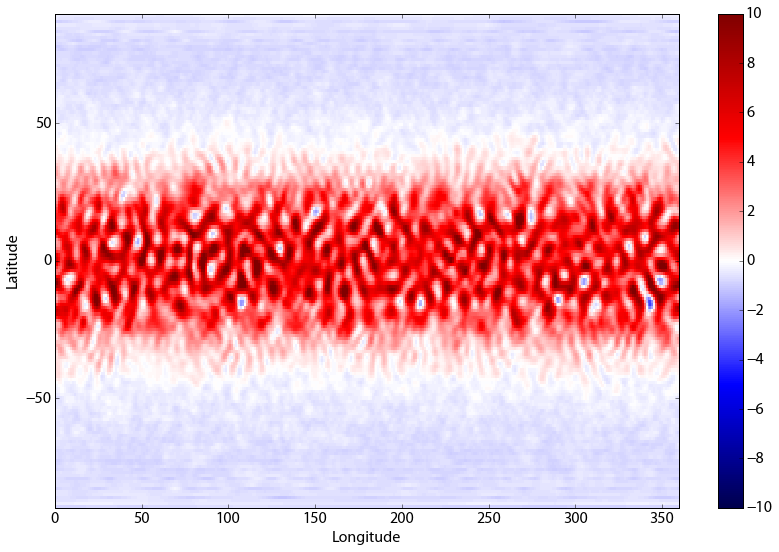

In [84]:
plt.figure(figsize=(6,4))
dims, phi = get_var('phi', phic_file)
phiref = 100.0
plot_map(phi[500] - phiref)
plt.clim(-10, 10)
plt.colorbar()
save_charts('exp1_phi_1000', overwrite=True)

## Experiment 2 - Gaussian sink profile

**Basic Parameters**
* run length: 600 days
* dt = 900s
* grid size: (320, 160)
* $\phi_{ref} = 100$

**Forcing parameters**
* $\dot\Sigma = 1.18\times10^{-4}$
* $R_0 = 3º$ 
* $\tau_c = 0.25 \text{ days}$
* $q_0 = 0.01$
* $r = \dot\Sigma \cdot q_0$

**Forcing setup**
* sink: $ r \exp(-(\frac{\theta}{5 \cdot R_0})^2) $
* source: $ q $
* threshold: $\phi_{ref}$
* initial conditions: $\phi_{ref} + q_0 \frac{\tau_c}{\Delta t} \cdot \text{rand}[0,1] $

**Notes**

Previous experiments have shown that it is the sink, not the phi threshold that appear to exert the greater control over where convective events occur.

With that in mind, trying a slightly different approach - using a gaussian decay profile on the sink term

In [123]:
exp2_file = 'data/run_data_20150707_114748.nc'


save_chart: image saved to images/exp2_conv.png
save_chart: image saved to images/exp2_conv.pdf


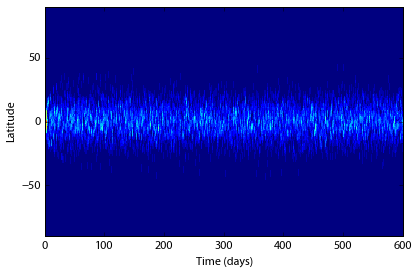

In [134]:
dims, conv = get_var('phi_lat', exp2_file)
plt.figure(figsize=(6,4))
plot_convection(dims, conv)
plt.xlim((0, 600))
save_charts('exp2_conv', overwrite=True)

save_chart: image saved to images/exp2_phi_1000.png
save_chart: image saved to images/exp2_phi_1000.pdf


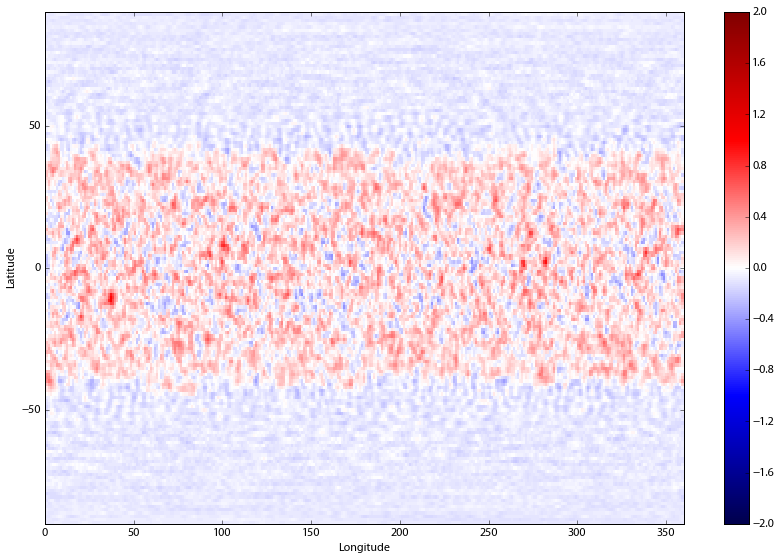

In [131]:
plt.figure(figsize=(6,4))
dims, phi = get_var('phi', exp2_file)
phiref = 100.0
plot_map(phi[1000] - phi[1000].mean())
plt.clim(-2, 2)
plt.colorbar()
save_charts('exp2_phi_1000', overwrite=True)

save_chart: not overwriting existing file
save_chart: not overwriting existing file


/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:51: RuntimeWarning: invalid value encountered in sqrt
/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:52: RuntimeWarning: invalid value encountered in sqrt


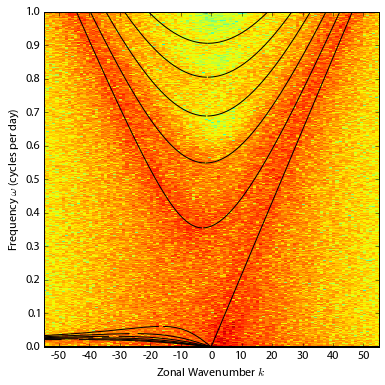

In [136]:
hdims, hu = get_var('u', exp2_file)
hg_spec = kiladis_spectra(hdims, hu, spinup=140)
hhd = convert_dims(hdims)
plt.figure(figsize=(6,6))

# without background
hsym_power = power(remove_background(hg_spec[np.abs(hhd[2]) < 15].sum(0)))
#rasym_power = power(remove_background(hg_spec[stropics].sum(0) - hg_spec[ntropics].sum(0)))
plot_power_spectra(hsym_power)
axis_cycles_per_day()
plt.xlim((-55/rearth, 55/rearth))
save_charts('exp2_spec')

save_chart: image saved to images/exp2_asym_spec.png
save_chart: image saved to images/exp2_asym_spec.pdf


/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:51: RuntimeWarning: invalid value encountered in sqrt
/scratch/jp492/envs/ipyserv/lib/python2.7/site-packages/IPython/kernel/__main__.py:52: RuntimeWarning: invalid value encountered in sqrt


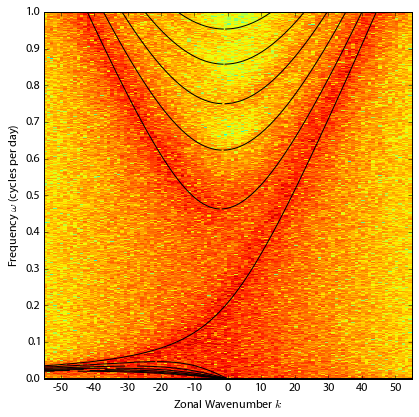

In [135]:
plt.figure(figsize=(6,6))
hasym_power = power(remove_background(hg_spec[stropics].sum(0) - hg_spec[ntropics].sum(0)))
plot_power_spectra(hasym_power, m=(0,2,4,6,8,10,12), kelvin=False)
axis_cycles_per_day()
plt.xlim((-55/rearth, 55/rearth))
save_charts('exp2_asym_spec', overwrite=True)